# Dashcam Analysis

### 1.   Introduction

This assignment had the aim of analyzing two dashcam videos taken with the same car/dashcam. There were 4 points of analytics; number of parked cars passed, number of moving cars passed, number of pedestrians passed, and the maximum speed in km/hour of the car with the dashcam. I mainly used the YOLO model, a state-of-the-art object detection system, and Supervision for object counting and video processing including annotations.

### 2.   Methods

The object detection model that was used was the YOLOv8n, which is the fastest model pre-trained on COCO that Ultralytics provides.[1] Out of 80 classes, persons (class number 0) and cars (class number 2) were regarded only, assuming that every "person" is a pedestrian. For object tracking, I used ByteTrack, which outperforms other tracking algorithms such as SORT and DeepSORT in running speed.[2] ByteTrack was chosen with the view of real-time implementations of this software. The track buffer, which keeps frames to it when a buffer is lost was set to the frame rate, making the assumption that the exact same car/pedestrian will not reappear in the video after an interval of 1 second. Using Supervision, I defined individual line zones in the bottom corners to count pedestrians and cars that pass from farther front to closer. The trigger of this line increments the object counter when the center of a detected object crosses the line. The line was adjusted to a position where it covers the whole driveway for cars and where it extends to the sidewalks for pedestrians. The number of cars were counted altogether, not distinguishing whether they were parked or driving. The time of video processing was measured and the ground truth of the number of cars and pedestrians passed was counted manually by myself.


### 3.   Results

Table 1 shows confusion matrices of the number of cars/pedestrians the dashcam passed. The true-negative entries are empty because any object that crosses the line zone but is not a car/pedestrian and thus does not increment the car/pedestrian count is considered a true-negative, and could not be counted manually. Table 2 shows the precisions and sensitivities calculated from Table 1. According to Table 2, while all of the entries had a precision higher than 0.9, the sensitivity was low for pedestrians in both videos. From observing the annotated videos, miscountings were caused by several phenomena. For false-negatives, the most common cause was occlusion. Cars were occluded by other vehicles and pedestrians were occluded by other pedestrians, vehicles, street light poles and trash cans. Pedestrians were also undetected due to lighting issues especially darkness. False-positives were rare, but there were cases where a biker was counted as a pedestrian or where in the end of the mcgill_drive.mp4, a car was counted even though it didn't fully pass. Table 3 shows the time it took to process the videos. The time to process each frame was around 0.1 seconds.
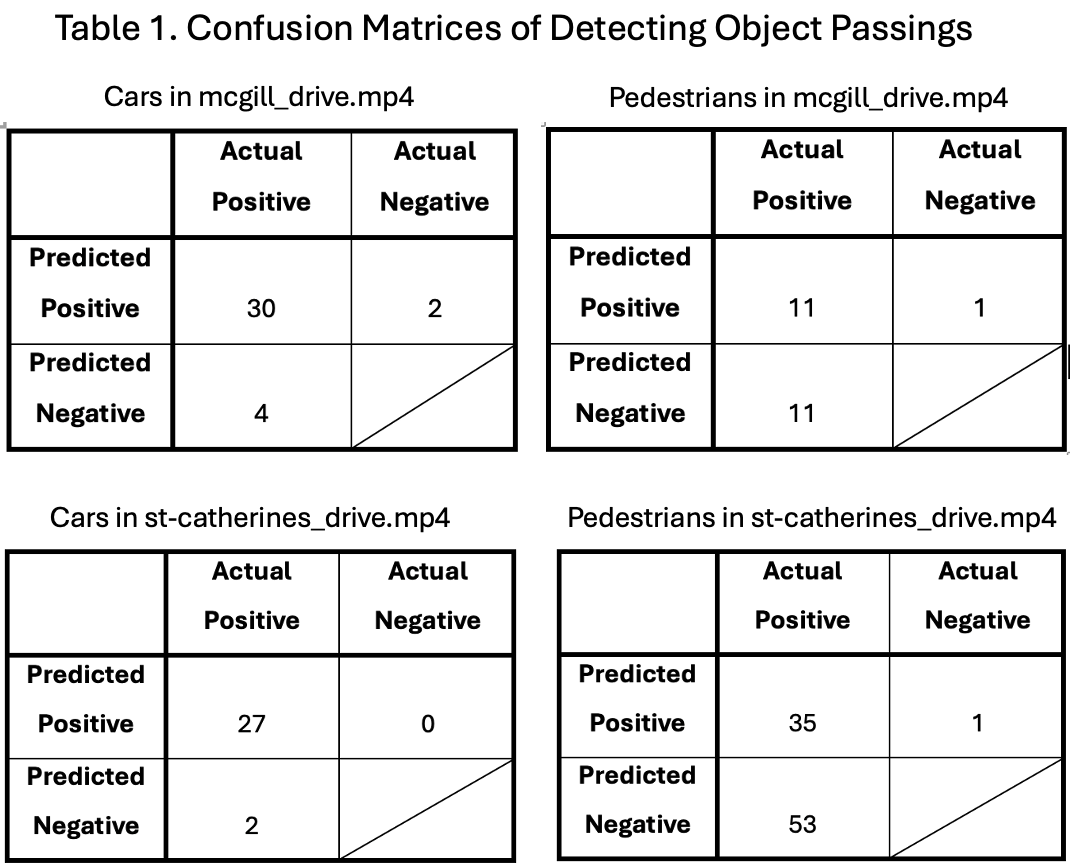

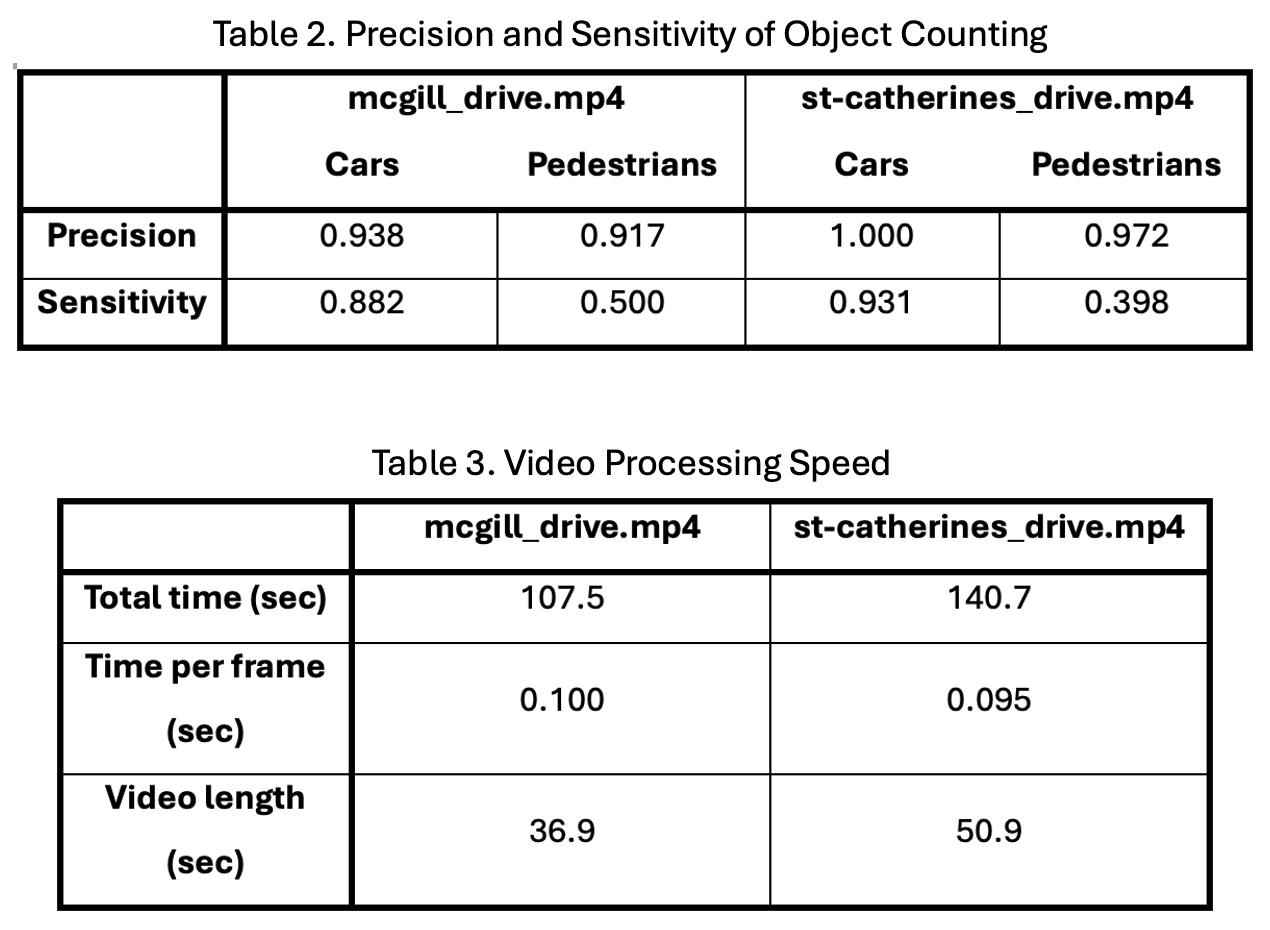

### 4.   Discussion and Conclusion

#### 4.1 Counting Performance

Cars were counted more accurately than pedestrians because of the difficulty of detection. Pedestrians are smaller in size and are more prone to occlusions. What's more, pedestrians tend to walk on sidewalks were there are big areas of shadow from buildings and trees. Therefore, the darkness can also be an issue in detecting them. On the other hand, the counting algorithm did not seem to be the bottleneck of miscounting objects. Line zones were well placed to capture various passings of cars and pedestrians. However, there can be some problematic cases. For example, if a pedestrian walks across the street or a car drives from right to left (or vice versa) close to the dashcam, these detections may cross over the line zone and increment the counter. Another case may be one where a car is driving beside at around the same speed and moves back and forth, this can increment the counter multiple times if the time of moving out of frame is longer than the track buffer.

#### 4.2 Distinguishing Parked/Driving Cars

One of the objectives of this assignment was to count parked and driving cars separately, but was not achieved. One way that this could have been achieved was to measure the optical flow. If the optical flow of the background and that of a detected car is similar, it can be said that the car is not moving. Otherwise, it is driving. However, we have to make an assumption that every car that is not moving is parked. There are cases where a car is stopping at an intersection waiting to turn and this car would be counted as a parked car. One way that could solve this is to check whether the tail light is lit or not. If it is lit, it means that the car is stopping temporarily and if it is not lit, it is parked.

#### 4.3 Distinguishing Pedestrians and Bikers

I used the person class to detect pedestrians, but not all people are pedestrians. As mentioned in the results, a biker was counted as a pedestrian because the person riding the bike was dected and crossed the line. One way that could solve this issue is to detect bikes and if a detected person is within a threshold distance from a bike, we can assume that the person is biking and we should not count this person as a pedestrian even if they cross the line. However, this could cause miscounting when a pedestrian is walking near a parked bike.

#### 4.4 Speed Estimation of Car with Dashcam

Estimating the maximum speed of the car with the dashcam was one of the objectives of the assignment, but was not achieved. From measuring or estimating a distance between trees or lights on the side, we can map the dashcam perspective to real world coordinates. This allows us to calculate the displacement of objects in real world measurements.[3] From this, we can get the velocity of the background or immovable objects and the sign inverted velocity would be the speed of the car with the dashcam. By constantly calculating this speed, we can gain the maximum speed of the car.

### 5. Reference

[1] https://docs.ultralytics.com/models/yolov8/#supported-tasks-and-modes

[2] https://www.mdpi.com/2079-9292/13/1/242

[3] https://blog.roboflow.com/estimate-speed-computer-vision/



# Source Code

## Preparation

### Paths and Libraries

In [2]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Working Directory Path
PATH = "/content/drive/MyDrive/ECSE415/Assignment 6"

# Paths of videos to be analized
SOURCE_VIDEO_PATH_1 = f"{PATH}/source/mcgill_drive.mp4"
SOURCE_VIDEO_PATH_2 = f"{PATH}/source/st-catherines_drive.mp4"
SOURCE_VIDEO_PATH_TEST = f"{PATH}/source/mcgill_drive_test.mp4"

# Paths of post-analysis videos with annotations
TARGET_VIDEO_PATH_1 = f"{PATH}/target/mcgill_drive_result.mp4"
TARGET_VIDEO_PATH_2 = f"{PATH}/target/st-catherines_drive_result.mp4"
TARGET_VIDEO_PATH_TEST = f"{PATH}/target/mcgill_drive_test_result.mp4"

In [4]:
# Basic Libraries
import time
import cv2
import numpy as np

import google.colab
from google.colab.patches import cv2_imshow

import IPython
from IPython import display

In [5]:
print(f"cv2: {cv2.__version__}")
print(f"numpy: {np.__version__}")

print(f"google: {google.colab.__version__}")
print(f"IPython: {IPython.__version__}")

cv2: 4.8.0
numpy: 1.25.2
google: 0.0.1a2
IPython: 7.34.0


### Install Ultralytics

In [8]:
!pip install ultralytics
display.clear_output()

In [9]:
import ultralytics
from ultralytics import YOLO
ultralytics.checks()

Ultralytics YOLOv8.1.47 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 29.0/201.2 GB disk)


### Install Roboflow Supervision

In [10]:
!pip install supervision
display.clear_output()

In [11]:
import supervision as sv
print(f"supervision: {sv.__version__}")

supervision: 0.19.0


# Main

### Load pre-trained YOLO model

In [12]:
# Load the YOLOv8 model
model = YOLO('yolov8n.pt')
model.fuse()

100%|██████████| 6.23M/6.23M [00:00<00:00, 107MB/s]


YOLOv8n summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs


** CLASS NAMES **


{0: 'person',
 1: 'bicycle',
 2: 'car',
 3: 'motorcycle',
 4: 'airplane',
 5: 'bus',
 6: 'train',
 7: 'truck',
 8: 'boat',
 9: 'traffic light',
 10: 'fire hydrant',
 11: 'stop sign',
 12: 'parking meter',
 13: 'bench',
 14: 'bird',
 15: 'cat',
 16: 'dog',
 17: 'horse',
 18: 'sheep',
 19: 'cow',
 20: 'elephant',
 21: 'bear',
 22: 'zebra',
 23: 'giraffe',
 24: 'backpack',
 25: 'umbrella',
 26: 'handbag',
 27: 'tie',
 28: 'suitcase',
 29: 'frisbee',
 30: 'skis',
 31: 'snowboard',
 32: 'sports ball',
 33: 'kite',
 34: 'baseball bat',
 35: 'baseball glove',
 36: 'skateboard',
 37: 'surfboard',
 38: 'tennis racket',
 39: 'bottle',
 40: 'wine glass',
 41: 'cup',
 42: 'fork',
 43: 'knife',
 44: 'spoon',
 45: 'bowl',
 46: 'banana',
 47: 'apple',
 48: 'sandwich',
 49: 'orange',
 50: 'broccoli',
 51: 'carrot',
 52: 'hot dog',
 53: 'pizza',
 54: 'donut',
 55: 'cake',
 56: 'chair',
 57: 'couch',
 58: 'potted plant',
 59: 'bed',
 60: 'dining table',
 61: 'toilet',
 62: 'tv',
 63: 'laptop',
 64: 'mouse',
 65: 'remote',
 66: 'keyboard',
 67: 'cell phone',
 68: 'microwave',
 69: 'oven',
 70: 'toaster',
 71: 'sink',
 72: 'refrigerator',
 73: 'book',
 74: 'clock',
 75: 'vase',
 76: 'scissors',
 77: 'teddy bear',
 78: 'hair drier',
 79: 'toothbrush'}

In [13]:
# Class labels
CLASS_NAMES_DICT = model.names
PEDESTRIAN_CLASSES = [0]
CAR_CLASSES = [2]

In [14]:
# Lines for counting cars
CAR_LINE_START_LEFT = sv.Point(1000, 1400)
CAR_LINE_END_LEFT = sv.Point(200, 1000)
CAR_LINE_START_RIGHT = sv.Point(2562 - 200, 1000)
CAR_LINE_END_RIGHT = sv.Point(2562 - 1000, 1400)

# Lines for counting pedestrians
PED_LINE_START_LEFT = sv.Point(600, 1400)
PED_LINE_END_LEFT = sv.Point(50, 900)
PED_LINE_START_RIGHT = sv.Point(2562 - 50, 900)
PED_LINE_END_RIGHT = sv.Point(2562 - 600, 1400)

### Testing annotations

In [15]:
"""
# Create frame generator
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

# create LineZone instance
line_zone_1 = sv.LineZone(start=CAR_LINE_START_1, end=CAR_LINE_END_1)
line_zone_2 = sv.LineZone(start=CAR_LINE_START_2, end=CAR_LINE_END_2)

# create instance of BoxAnnotator
box_annotator = sv.BoxAnnotator(thickness=2, text_thickness=2, text_scale=1)

# create LineZoneAnnotator instance
car_line_zone_annotator = sv.LineZoneAnnotator(thickness=4, text_thickness=2, text_scale=1, display_in_count=False, display_out_count=False, color=sv.Color(253, 179, 166))
pedestrian_line_zone_annotator = sv.LineZoneAnnotator(thickness=4, text_thickness=2, text_scale=1, display_in_count=False, display_out_count=False, color=sv.Color(169, 106, 245))

for i in range(1):
  # acquire first video frame
  iterator = iter(generator)
  frame = next(iterator)

  # model prediction on single frame and conversion to supervision Detections
  results = model(frame, verbose=False)[0]

  # convert to Detections
  detections = sv.Detections.from_ultralytics(results)
  # only consider class id from selected_classes define above
  detections = detections[np.isin(detections.class_id, CAR_CLASSES)]

  # format custom labels
  labels = [
      f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
      for confidence, class_id in zip(detections.confidence, detections.class_id)
  ]

  # annotate and display frame
  annotated_frame=box_annotator.annotate(scene=frame, detections=detections, labels=labels)

  annotated_frame = car_line_zone_annotator.annotate(annotated_frame, line_counter=line_zone_1)
  annotated_frame = car_line_zone_annotator.annotate(annotated_frame, line_counter=line_zone_2)

  annotated_frame = sv.draw_text(scene=annotated_frame, text=f"Cars passed: 0", text_anchor=sv.Point(x=1281, y=50), text_scale=1, background_color=sv.Color(255, 182, 50))
  annotated_frame = sv.draw_text(scene=annotated_frame, text=f"Pedestrians passed: 0", text_anchor=sv.Point(x=1281, y=100), text_scale=1, background_color=sv.Color(255, 182, 50))

  display.clear_output(wait=True)
  %matplotlib inline
  sv.plot_image(annotated_frame, (16,16))
"""

'\n# Create frame generator\ngenerator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)\n\n# create LineZone instance\nline_zone_1 = sv.LineZone(start=CAR_LINE_START_1, end=CAR_LINE_END_1)\nline_zone_2 = sv.LineZone(start=CAR_LINE_START_2, end=CAR_LINE_END_2)\n\n# create instance of BoxAnnotator\nbox_annotator = sv.BoxAnnotator(thickness=2, text_thickness=2, text_scale=1)\n\n# create LineZoneAnnotator instance\ncar_line_zone_annotator = sv.LineZoneAnnotator(thickness=4, text_thickness=2, text_scale=1, display_in_count=False, display_out_count=False, color=sv.Color(253, 179, 166))\npedestrian_line_zone_annotator = sv.LineZoneAnnotator(thickness=4, text_thickness=2, text_scale=1, display_in_count=False, display_out_count=False, color=sv.Color(169, 106, 245))\n\nfor i in range(1):\n  # acquire first video frame\n  iterator = iter(generator)\n  frame = next(iterator)\n\n  # model prediction on single frame and conversion to supervision Detections\n  results = model(frame, verbose=False)[

### Analyze and annotate videos

In [16]:
# Get video info
print(f"mcgill_drive.mp4: {sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH_1)}")
print(f"st-catherines_drive.mp4: {sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH_2)}")

mcgill_drive.mp4: VideoInfo(width=2562, height=1440, fps=29, total_frames=1071)
st-catherines_drive.mp4: VideoInfo(width=2562, height=1440, fps=29, total_frames=1477)


In [17]:
class VideoAnalyzer:
  def __init__(self, source_path, target_path):
    self.source_path = source_path
    self.target_path = target_path

  def analyze_video(self):
    # Get video info
    self.source_video_info = sv.VideoInfo.from_video_path(self.source_path)

    # Create BYTETracker instance
    self.car_byte_tracker = sv.ByteTrack(track_thresh=0.25, track_buffer=self.source_video_info.fps, match_thresh=0.8, frame_rate=self.source_video_info.fps)
    self.pedestrian_byte_tracker = sv.ByteTrack(track_thresh=0.25, track_buffer=self.source_video_info.fps, match_thresh=0.8, frame_rate=self.source_video_info.fps)

    # Create frame generator
    generator = sv.get_video_frames_generator(self.source_path)

    # Create LineZone instance
    # It increments object count if the center of detection passes these line zones
    # Different line zones are defined for cars and pedestrians
    self.car_line_zone_1 = sv.LineZone(start=CAR_LINE_START_LEFT, end=CAR_LINE_END_LEFT, triggering_anchors=[sv.Position.CENTER])
    self.car_line_zone_2 = sv.LineZone(start=CAR_LINE_START_RIGHT, end=CAR_LINE_END_RIGHT, triggering_anchors=[sv.Position.CENTER])
    self.pedestrian_line_zone_1 = sv.LineZone(start=PED_LINE_START_LEFT, end=PED_LINE_END_LEFT, triggering_anchors=[sv.Position.CENTER])
    self.pedestrian_line_zone_2 = sv.LineZone(start=PED_LINE_START_RIGHT, end=PED_LINE_END_RIGHT, triggering_anchors=[sv.Position.CENTER])

    # Create instance of annotators
    self.box_annotator = sv.BoxAnnotator(thickness=2, text_thickness=2, text_scale=1)
    self.trace_annotator = sv.TraceAnnotator(thickness=2, trace_length=50)
    self.car_line_zone_annotator = sv.LineZoneAnnotator(thickness=2,
                                                  text_thickness=2,
                                                  text_scale=1,
                                                  display_in_count=True,
                                                  display_out_count=False,
                                                  color=sv.Color(253, 179, 166))

    self.pedestrian_line_zone_annotator = sv.LineZoneAnnotator(thickness=2,
                                                          text_thickness=2,
                                                          text_scale=1,
                                                          display_in_count=True,
                                                          display_out_count=False,
                                                          color=sv.Color(169, 106, 245))

    # Process the whole video
    start_time = time.time()
    sv.process_video(source_path=self.source_path, target_path=self.target_path, callback=self.callback)
    self.process_time = time.time() - start_time

  # Call back function to be used in video processing
  def callback(self, frame: np.ndarray, index:int) -> np.ndarray:
    # Model prediction on single frame and conversion to supervision Detections
    results = model(frame, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    # Only consider detections of cars and pedestrians
    car_detections = detections[np.isin(detections.class_id, CAR_CLASSES)]
    pedestrian_detections = detections[np.isin(detections.class_id, PEDESTRIAN_CLASSES)]

    # Tracking detections using byte tracker
    car_detections = self.car_byte_tracker.update_with_detections(car_detections)
    pedestrian_detections = self.pedestrian_byte_tracker.update_with_detections(pedestrian_detections)

    # Label tracked objects
    car_labels = [
        f"#{tracker_id} {model.model.names[class_id]} {confidence:0.2f}"
        for confidence, class_id, tracker_id
        in zip(car_detections.confidence, car_detections.class_id, car_detections.tracker_id)
    ]

    pedestrian_labels = [
        f"#{tracker_id} {model.model.names[class_id]} {confidence:0.2f}"
        for confidence, class_id, tracker_id
        in zip(pedestrian_detections.confidence, pedestrian_detections.class_id, pedestrian_detections.tracker_id)
    ]

    # Annotate each frame
    annotated_frame = self.trace_annotator.annotate(scene=frame.copy(), detections=car_detections)
    annotated_frame = self.trace_annotator.annotate(scene=annotated_frame, detections=pedestrian_detections)
    annotated_frame = self.box_annotator.annotate(scene=annotated_frame, detections=car_detections, labels=car_labels)
    annotated_frame = self.box_annotator.annotate(scene=annotated_frame, detections=pedestrian_detections, labels=pedestrian_labels)

    # Update line counter
    self.car_line_zone_1.trigger(car_detections)
    self.car_line_zone_2.trigger(car_detections)
    self.pedestrian_line_zone_1.trigger(pedestrian_detections)
    self.pedestrian_line_zone_2.trigger(pedestrian_detections)

    # Count cars/pedestrians that crossed the line
    # In this case, "in_count" is the crossing from farther front to closer
    num_cars_passed = self.car_line_zone_1.in_count + self.car_line_zone_2.in_count
    num_pedestrians_passed = self.pedestrian_line_zone_1.in_count + self.pedestrian_line_zone_2.in_count

    # Annotate counter
    annotated_frame = sv.draw_text(scene=annotated_frame,
                                  text=f"Cars passed: {num_cars_passed}",
                                  text_anchor=sv.Point(x=1281, y=50),
                                  text_scale=1,
                                  background_color=sv.Color(255, 182, 50))

    annotated_frame = sv.draw_text(scene=annotated_frame,
                                  text=f"Pedestrians passed: {num_pedestrians_passed}",
                                  text_anchor=sv.Point(x=1281, y=100),
                                  text_scale=1,
                                  background_color=sv.Color(255, 182, 50))

    # return frame with box and line annotated result
    annotated_frame = self.car_line_zone_annotator.annotate(annotated_frame, line_counter=self.car_line_zone_1)
    annotated_frame = self.car_line_zone_annotator.annotate(annotated_frame, line_counter=self.car_line_zone_2)
    annotated_frame = self.pedestrian_line_zone_annotator.annotate(annotated_frame, line_counter=self.pedestrian_line_zone_1)
    annotated_frame = self.pedestrian_line_zone_annotator.annotate(annotated_frame, line_counter=self.pedestrian_line_zone_2)

    return annotated_frame


  def get_process_time(self, per_frame=True):
    if per_frame:
      print(f"Video Process Time (per frame): {(self.process_time / self.source_video_info.total_frames):.3f}s")
    else:
      print(f"Video Process Time (total): {self.process_time:.3f}s")

### REFERENCE ###
# Object Tracking
#   https://docs.ultralytics.com/modes/track/#tracker-selection

# Object Counting
#   https://github.com/roboflow/supervision
#   https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/how-to-track-and-count-vehicles-with-yolov8-and-supervison.ipynb#scrollTo=ZuNPZ2hvHeZV

In [18]:
video_analyzer_1 = VideoAnalyzer(SOURCE_VIDEO_PATH_1, TARGET_VIDEO_PATH_1)
video_analyzer_1.analyze_video()
display.clear_output()

In [19]:
video_analyzer_1.get_process_time()
video_analyzer_1.get_process_time(per_frame=False)

Video Process Time (per frame): 0.100s
Video Process Time (total): 107.490s


In [20]:
video_analyzer_2 = VideoAnalyzer(SOURCE_VIDEO_PATH_2, TARGET_VIDEO_PATH_2)
video_analyzer_2.analyze_video()
display.clear_output()

In [21]:
video_analyzer_2.get_process_time()
video_analyzer_2.get_process_time(per_frame=False)

Video Process Time (per frame): 0.095s
Video Process Time (total): 140.712s
